In [1]:
import tensorflow.keras as keras
import tensorflow as tf
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import uproot
import pandas as pd
import awkward as ak
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import tensorflow_decision_forests as tfdf
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots
from keras.callbacks import LearningRateScheduler

In [17]:
def open_root_files(file_names,tree):
    file = uproot.open(file_names)
    tree_name = file[tree]
    return tree_name

def create_heat_map(df):
    corr = df.corr()
    sns.heatmap(corr, 
    cmap='RdYlGn', 
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values)
    plt.show()

def create_tensor_object(train_variables,dict):
    df = pd.DataFrame()
    key = list(dict.keys())[0]
    for var in train_variables:
        if var == "classification":
            continue
        else:
            df[var] = np.array(dict[key][var].array())
    if "signal" in key:
        print("SIGNAL CLASSIFICATION SET TO 1", key)
        df.insert(0, 'classification', 1)
    else:
        print("BACKGROUND CLASSIFICATION SET TO 0", key)
        df.insert(0, 'classification', 0)
    
    #split the data into train and testing set
    train_df, test_df = train_test_split(df, test_size=0.2)
    
    train_df, val_df = train_test_split(train_df, test_size=0.2)
    
    train_df.filter(train_df['weight'] > 0)
    test_df.filter(test_df['weight'] > 0)
    val_df.filter(val_df['weight'] > 0)
    
    train_df_class = train_df.pop('classification')
    train_df_weights = train_df.pop('weight')
    test_df_class = test_df.pop('classification')
    test_df_weights = test_df.pop('weight')
    val_df_class = val_df.pop('classification')
    val_df_weights = val_df.pop('weight')

    #create heat map of training variables
    hmap = create_heat_map(train_df)
    
    return train_df, train_df_class, train_df_weights, test_df, test_df_class, test_df_weights, val_df, val_df_class, val_df_weights

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()
    
def plot_loss(fit):
    plt.plot(fit.history['loss'])
    plt.plot(fit.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def plot_accuracy(fit):
    plt.plot(fit.history['accuracy'])
    plt.plot(fit.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
def custom_LearningRate_schedular(epoch):
    if epoch < 5:
        return 0.01
    else:
        return 0.01 * tf.math.exp(0.1 * (10 - epoch))

    
def get_model(metric, bias, train_tensor):
    model = keras.Sequential([
    keras.layers.Dense(4, activation='relu', input_shape=(train_tensor.shape[1],), bias_initializer=keras.initializers.Constant(bias)),
    # keras.layers.Dense(128, activation='relu'),
    # keras.layers.Dense(128, activation='relu'),
    # keras.layers.Dense(128, activation='relu'),
    # keras.layers.Dense(128, activation='relu'),
    # keras.layers.Dense(64, activation='relu'),
    # keras.layers.Dense(64, activation='relu'),
    # keras.layers.Dense(64, activation='relu'),
    # keras.layers.Dense(64, activation='relu'),
    # keras.layers.Dense(32, activation='relu'),
    # keras.layers.Dense(16, activation='relu'),
    # keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
    ])
    model.compile(optimizer=tf.optimizers.SGD(learning_rate=0.001),
                loss=tf.keras.losses.BinaryCrossentropy(
                        name='binary_crossentropy'),
                metrics=[metric])
    # model.layers[0].bias.assign([bias])
    return model


In [3]:
#open the files
signal_file_e = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16e_signal.root","nominal")
#signal_file_d = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16d_signal.root","nominal")
#signal_file_a = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16a_signal.root","nominal")
ttbar_file_e = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16e_ttbar.root","nominal")
#ttbar_file_d = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16d_ttbar.root","nominal")
#ttbar_file_a = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16a_ttbar.root","nominal")
#wjets_file_e = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16e_wjets.root","nominal")
#wjets_file_d = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16d_wjets.root","nominal")
#wjets_file_a = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16a_wjets.root","nominal")
#diboson_file_e = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16e_diboson.root","nominal")
#diboson_file_d = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16d_diboson.root","nominal")
#diboson_file_a = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16a_diboson.root","nominal")
#zjets_file_e = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16e_zjets.root","nominal")
#zjets_file_d = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16d_zjets.root","nominal")
#zjets_file_a = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16a_zjets.root","nominal")
#singletop_file_e = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16e_singletop.root","nominal")
#singletop_file_d = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16d_singletop.root","nominal")
#singletop_file_a = open_root_files("~/Physics/HWWAnalysis/ntuples/mc16a_singletop.root","nominal")

SIGNAL CLASSIFICATION SET TO 1 signal_e


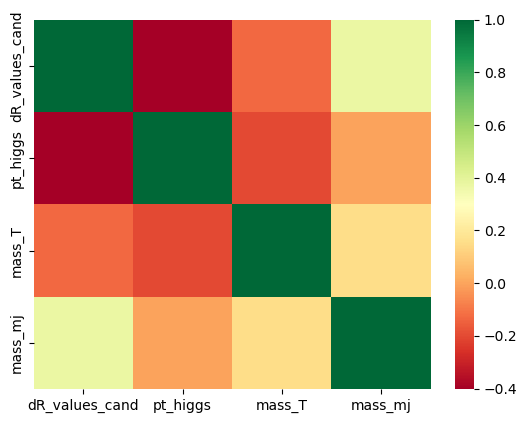

SIGNAL CLASSIFICATION SET TO 1 signal_d


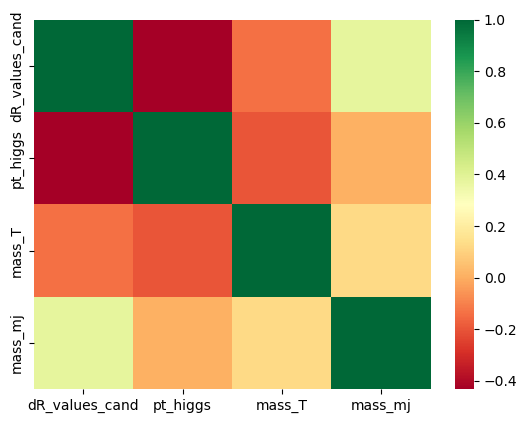

SIGNAL CLASSIFICATION SET TO 1 signal_a


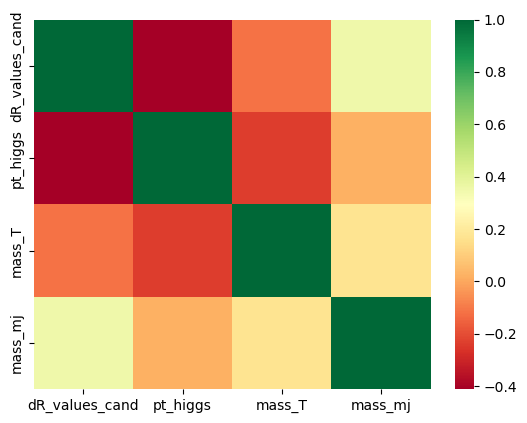

BACKGROUND CLASSIFICATION SET TO 0 ttbar_e


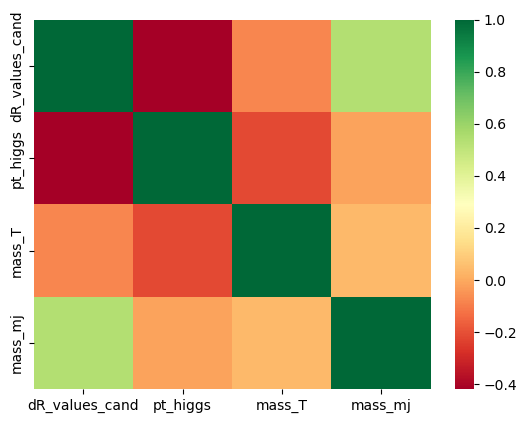

BACKGROUND CLASSIFICATION SET TO 0 ttbar_d


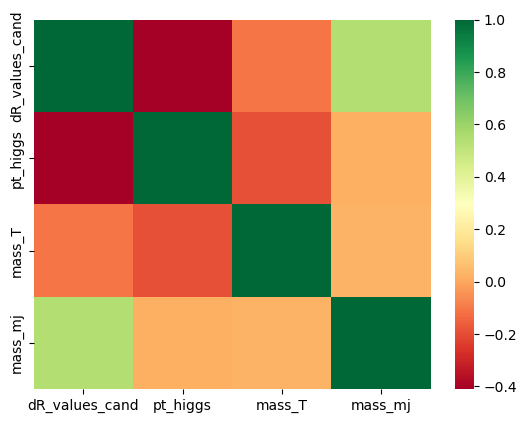

BACKGROUND CLASSIFICATION SET TO 0 ttbar_a


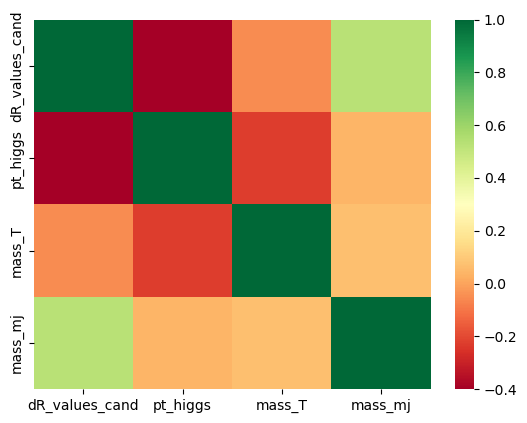

BACKGROUND CLASSIFICATION SET TO 0 wjets_e


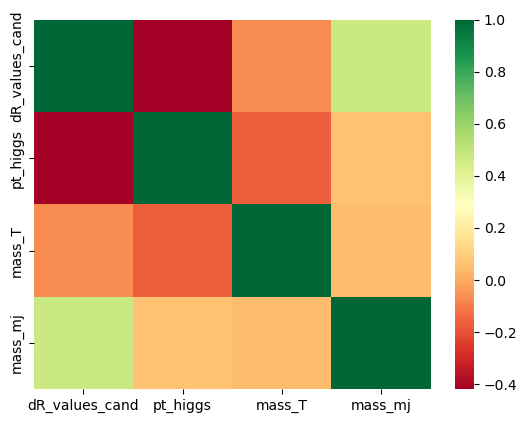

BACKGROUND CLASSIFICATION SET TO 0 wjets_d


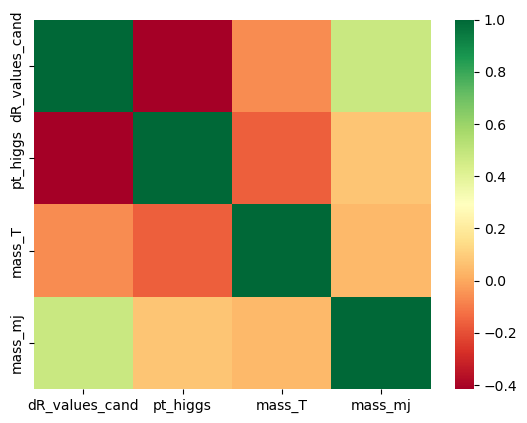

BACKGROUND CLASSIFICATION SET TO 0 wjets_a


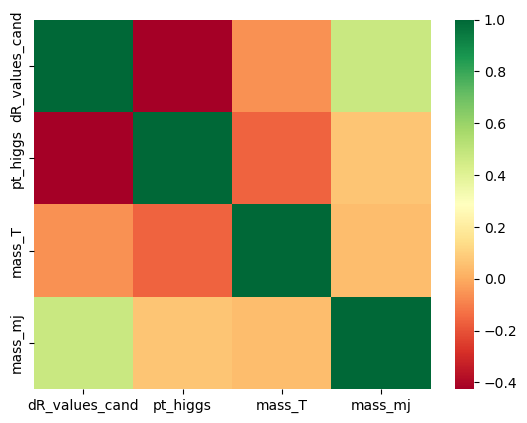

BACKGROUND CLASSIFICATION SET TO 0 diboson_e


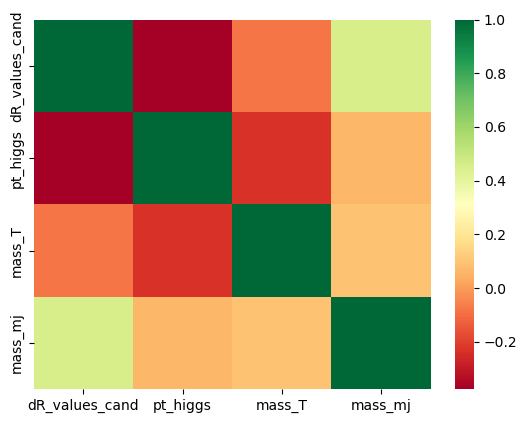

BACKGROUND CLASSIFICATION SET TO 0 diboson_d


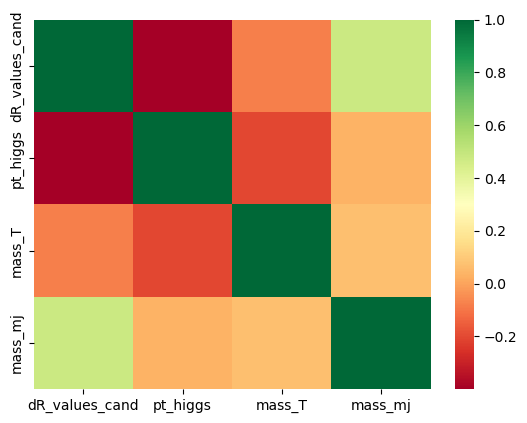

BACKGROUND CLASSIFICATION SET TO 0 diboson_a


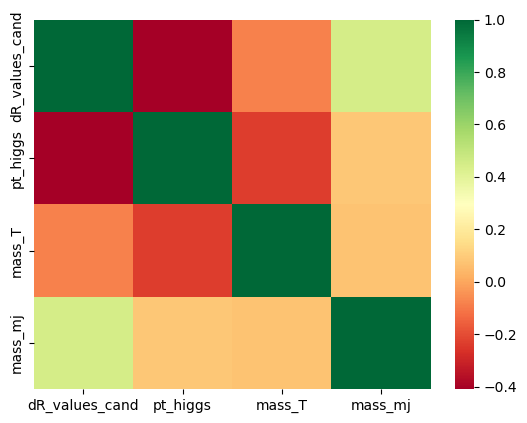

BACKGROUND CLASSIFICATION SET TO 0 singletop_e


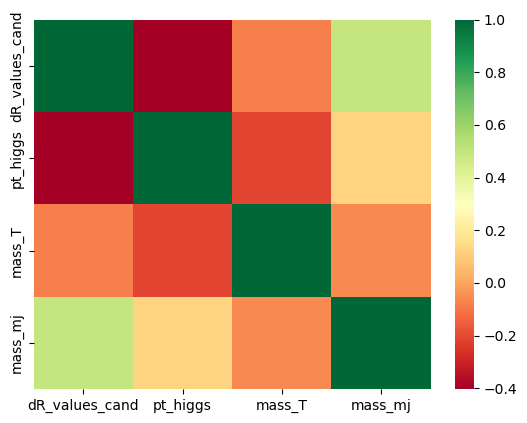

BACKGROUND CLASSIFICATION SET TO 0 singletop_d


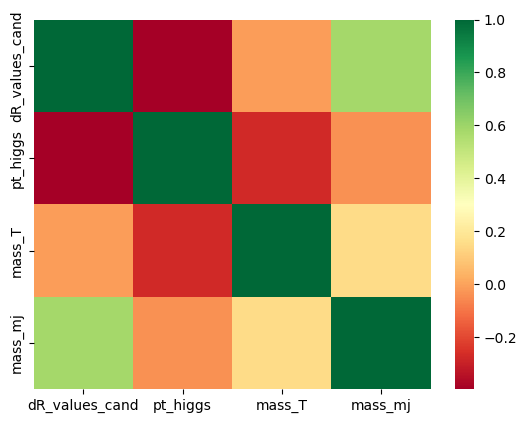

BACKGROUND CLASSIFICATION SET TO 0 singletop_a


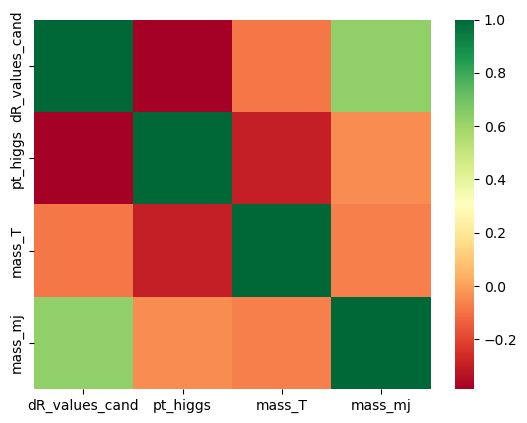

BACKGROUND CLASSIFICATION SET TO 0 zjets_e


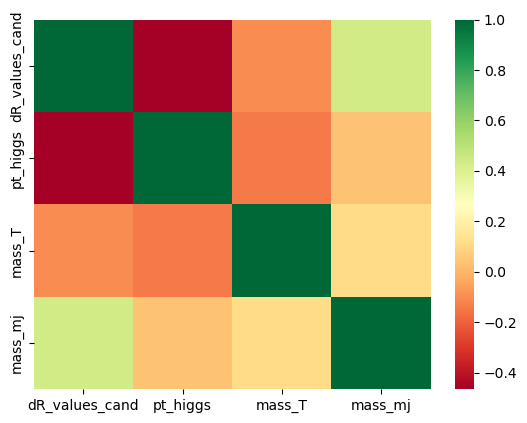

BACKGROUND CLASSIFICATION SET TO 0 zjets_d


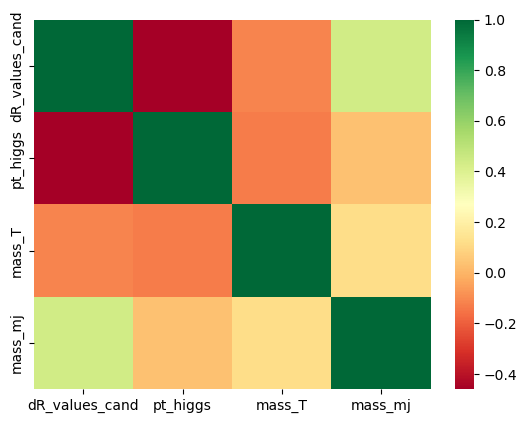

BACKGROUND CLASSIFICATION SET TO 0 zjets_a


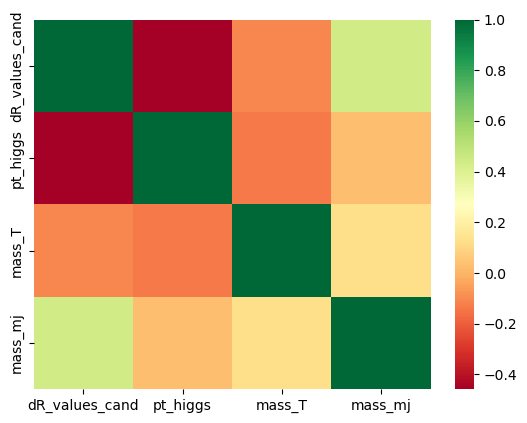

Examples:  Total: 88179  Positive: 4880  Negative: 83299  Ratio: 0.05534197484661881
Weighted Training Events:  Total: 1448.6701914921712  Positive: 32.47597637323332  Negative: 1416.1942151189378  Ratio: 0.02241778464412397
Weighted Test Events:  Total: 453.4215043647719  Positive: 10.105984060765016  Negative: 443.3155203040069  Ratio: 0.022288276942054513
Weighted Validation Events:  Total: 376.7483210461131  Positive: 8.124907188659902  Negative: 368.6234138574532  Ratio: 0.021565874974836138
Total Events:  Total: 2278.840016903056  Positive: 50.706867622658244  Negative: 2228.133149280398  Ratio: 0.022251174828660805


In [19]:
# variables = ['classification','mupt_cand', 'mueta_cand', 'muphi_cand', 'ljet_pt_cand', 'ljet_eta_cand',\
#                    'ljet_phi_cand', 'ljet_mass_cand', 'dR_values_cand', 'pt_higgs',\
#                    'mass_T', 'met_met', 'met_phi', 'mass_mj', 'weight']
# variables = ['classification','mupt_cand','ljet_pt_cand','ljet_mass_cand','dR_values_cand','pt_higgs','mass_T', 'met_met', 'mass_mj', 'weight']
variables = ['classification','dR_values_cand','pt_higgs','mass_T', 'mass_mj', 'weight']

signal_train_e, signal_train_class_e, signal_train_weights_e, signal_test_e, signal_test_class_e, signal_test_weights_e, signal_val_e, signal_val_class_e, signal_val_weights_e = create_tensor_object(variables, {"signal_e" : signal_file_e})
#signal_train_d, signal_train_class_d, signal_train_weights_d, signal_test_d, signal_test_class_d, signal_test_weights_d, signal_val_d, signal_val_class_d, signal_val_weights_d = create_tensor_object(variables, {"signal_d" : signal_file_d})
#signal_train_a, signal_train_class_a, signal_train_weights_a, signal_test_a, signal_test_class_a, signal_test_weights_a, signal_val_a, signal_val_class_a, signal_val_weights_a = create_tensor_object(variables, {"signal_a" : signal_file_a})
ttbar_train_e, ttbar_train_class_e, ttbar_train_weights_e, ttbar_test_e, ttbar_test_class_e, ttbar_test_weights_e, ttbar_val_e, ttbar_val_class_e, ttbar_val_weights_e  = create_tensor_object(variables, {"ttbar_e" : ttbar_file_e})
#ttbar_train_d, ttbar_train_class_d, ttbar_train_weights_d, ttbar_test_d, ttbar_test_class_d, ttbar_test_weights_d, ttbar_val_d, ttbar_val_class_d, ttbar_val_weights_d  = create_tensor_object(variables, {"ttbar_d" : ttbar_file_d})
#ttbar_train_a, ttbar_train_class_a, ttbar_train_weights_a, ttbar_test_a, ttbar_test_class_a, ttbar_test_weights_a, ttbar_val_a, ttbar_val_class_a, ttbar_val_weights_a  = create_tensor_object(variables, {"ttbar_a" : ttbar_file_a})
#wjets_train_e, wjets_train_class_e, wjets_train_weights_e, wjets_test_e, wjets_test_class_e, wjets_test_weights_e, wjets_val_e, wjets_val_class_e, wjets_val_weights_e  = create_tensor_object(variables, {"wjets_e" : wjets_file_e})
#wjets_train_d, wjets_train_class_d, wjets_train_weights_d, wjets_test_d, wjets_test_class_d, wjets_test_weights_d, wjets_val_d, wjets_val_class_d, wjets_val_weights_d  = create_tensor_object(variables, {"wjets_d" : wjets_file_d})
#wjets_train_a, wjets_train_class_a, wjets_train_weights_a, wjets_test_a, wjets_test_class_a, wjets_test_weights_a, wjets_val_a, wjets_val_class_a, wjets_val_weights_a  = create_tensor_object(variables, {"wjets_a" : wjets_file_a})
#diboson_train_e, diboson_train_class_e, diboson_train_weights_e, diboson_test_e, diboson_test_class_e, diboson_test_weights_e, diboson_val_e, diboson_val_class_e, diboson_val_weights_e  = create_tensor_object(variables, {"diboson_e" : diboson_file_e})
#diboson_train_d, diboson_train_class_d, diboson_train_weights_d, diboson_test_d, diboson_test_class_d, diboson_test_weights_d, diboson_val_d, diboson_val_class_d, diboson_val_weights_d  = create_tensor_object(variables, {"diboson_d" : diboson_file_d})
#diboson_train_a, diboson_train_class_a, diboson_train_weights_a, diboson_test_a, diboson_test_class_a, diboson_test_weights_a, diboson_val_a, diboson_val_class_a, diboson_val_weights_a  = create_tensor_object(variables, {"diboson_a" : diboson_file_a})
#singletop_train_e, singletop_train_class_e, singletop_train_weights_e, singletop_test_e, singletop_test_class_e, singletop_test_weights_e, singletop_val_e, singletop_val_class_e, singletop_val_weights_e  = create_tensor_object(variables, {"singletop_e" : singletop_file_e})
#singletop_train_d, singletop_train_class_d, singletop_train_weights_d, singletop_test_d, singletop_test_class_d, singletop_test_weights_d, singletop_val_d, singletop_val_class_d, singletop_val_weights_d  = create_tensor_object(variables, {"singletop_d" : singletop_file_d})
#singletop_train_a, singletop_train_class_a, singletop_train_weights_a, singletop_test_a, singletop_test_class_a, singletop_test_weights_a, singletop_val_a, singletop_val_class_a, singletop_val_weights_a  = create_tensor_object(variables, {"singletop_a" : singletop_file_a})
#zjets_train_e, zjets_train_class_e, zjets_train_weights_e, zjets_test_e, zjets_test_class_e, zjets_test_weights_e, zjets_val_e, zjets_val_class_e, zjets_val_weights_e  = create_tensor_object(variables, {"zjets_e" : zjets_file_e})
#zjets_train_d, zjets_train_class_d, zjets_train_weights_d, zjets_test_d, zjets_test_class_d, zjets_test_weights_d, zjets_val_d, zjets_val_class_d, zjets_val_weights_d  = create_tensor_object(variables, {"zjets_d" : zjets_file_d})
#zjets_train_a, zjets_train_class_a, zjets_train_weights_a, zjets_test_a, zjets_test_class_a, zjets_test_weights_a, zjets_val_a, zjets_val_class_a, zjets_val_weights_a  = create_tensor_object(variables, {"zjets_a" : zjets_file_a})

#train_df = pd.concat([signal_train_e, signal_train_d, signal_train_a, ttbar_train_e, ttbar_train_d, ttbar_train_a, diboson_train_e, diboson_train_d, diboson_train_a, singletop_train_e, singletop_train_d, singletop_train_a, zjets_train_e, zjets_train_d, zjets_train_a])
#train_class = np.concatenate([signal_train_class_e, signal_train_class_d, signal_train_class_a, ttbar_train_class_e, ttbar_train_class_d, ttbar_train_class_a, diboson_train_class_e, diboson_train_class_d, diboson_train_class_a, singletop_train_class_e, singletop_train_class_d, singletop_train_class_a, zjets_train_class_e, zjets_train_class_d, zjets_train_class_a])
#train_weight = np.concatenate([signal_train_weights_e, signal_train_weights_d, signal_train_weights_a, ttbar_train_weights_e, ttbar_train_weights_d, ttbar_train_weights_a, diboson_train_weights_e, diboson_train_weights_d, diboson_train_weights_a, singletop_train_weights_e, singletop_train_weights_d, singletop_train_weights_a, zjets_train_weights_e, zjets_train_weights_d, zjets_train_weights_a])

train_df = pd.concat([signal_train_e, ttbar_train_e])
train_class = np.concatenate([signal_train_class_e, ttbar_train_class_e])
train_weight = np.concatenate([signal_train_weights_e, ttbar_train_weights_e])

#test_df = pd.concat([signal_test_e, signal_test_d, signal_test_a, ttbar_test_e, ttbar_test_d, ttbar_test_a, diboson_test_e, diboson_test_d, diboson_test_a, singletop_test_e, singletop_test_d, singletop_test_a, zjets_test_e, zjets_test_d, zjets_test_a])
#test_class = np.concatenate([signal_test_class_e, signal_test_class_d, signal_test_class_a, ttbar_test_class_e, ttbar_test_class_d, ttbar_test_class_a, diboson_test_class_e, diboson_test_class_d, diboson_test_class_a, singletop_test_class_e, singletop_test_class_d, singletop_test_class_a, zjets_test_class_e, zjets_test_class_d, zjets_test_class_a])
#test_weight = np.concatenate([signal_test_weights_e, signal_test_weights_d, signal_test_weights_a, ttbar_test_weights_e, ttbar_test_weights_d, ttbar_test_weights_a, diboson_test_weights_e, diboson_test_weights_d, diboson_test_weights_a, singletop_test_weights_e, singletop_test_weights_d, singletop_test_weights_a, zjets_test_weights_e, zjets_test_weights_d, zjets_test_weights_a])

test_df = pd.concat([signal_test_e, ttbar_test_e])
test_class = np.concatenate([signal_test_class_e, ttbar_test_class_e])
test_weight = np.concatenate([signal_test_weights_e, ttbar_test_weights_e])

#val_df = pd.concat([signal_val_e, signal_val_d, signal_val_a, ttbar_val_e, ttbar_val_d, ttbar_val_a, diboson_val_e, diboson_val_d, diboson_val_a, singletop_val_e, singletop_val_d, singletop_val_a, zjets_val_e, zjets_val_d, zjets_val_a])
#val_class = np.concatenate([signal_val_class_e, signal_val_class_d, signal_val_class_a, ttbar_val_class_e, ttbar_val_class_d, ttbar_val_class_a, diboson_val_class_e, diboson_val_class_d, diboson_val_class_a, singletop_val_class_e, singletop_val_class_d, singletop_val_class_a, zjets_val_class_e, zjets_val_class_d, zjets_val_class_a])
#val_weight = np.concatenate([signal_val_weights_e, signal_val_weights_d, signal_val_weights_a, ttbar_val_weights_e, ttbar_val_weights_d, ttbar_val_weights_a, diboson_val_weights_e, diboson_val_weights_d, diboson_val_weights_a, singletop_val_weights_e, singletop_val_weights_d, singletop_val_weights_a, zjets_val_weights_e, zjets_val_weights_d, zjets_val_weights_a])

val_df = pd.concat([signal_val_e, ttbar_val_e])
val_class = np.concatenate([signal_val_class_e, ttbar_val_class_e])
val_weight = np.concatenate([signal_val_weights_e, ttbar_val_weights_e])

scaled_train_df = StandardScaler().fit_transform(train_df)
scaled_test_df = StandardScaler().fit_transform(test_df)
scaled_val_df = StandardScaler().fit_transform(val_df)

#print total number of events in each sample
neg, pos = np.bincount(train_class)
total = neg + pos
print('Examples:  Total: {}  Positive: {}  Negative: {}  Ratio: {}'.format(total, pos, neg, pos / total))
class_weight = {0: total/(2*neg), 1: total/(2*pos)}

#print weighted number of Total, Positive, Negative, and Ratio
neg_weighted, pos_weighted = np.bincount(train_class, weights=train_weight)
total_weighted = neg_weighted + pos_weighted
print('Weighted Training Events:  Total: {}  Positive: {}  Negative: {}  Ratio: {}'.format(total_weighted, pos_weighted, neg_weighted, pos_weighted / total_weighted))

#print weighted number of total, positive, negative, and ratio for test set 
neg_weighted_test, pos_weighted_test = np.bincount(test_class, weights=test_weight)
total_weighted_test = neg_weighted_test + pos_weighted_test
print('Weighted Test Events:  Total: {}  Positive: {}  Negative: {}  Ratio: {}'.format(total_weighted_test, pos_weighted_test, neg_weighted_test, pos_weighted_test / total_weighted_test))

#print weighted number of total, positive, negative, and ratio for validation set
neg_weighted_val, pos_weighted_val = np.bincount(val_class, weights=val_weight)
total_weighted_val = neg_weighted_val + pos_weighted_val
print('Weighted Validation Events:  Total: {}  Positive: {}  Negative: {}  Ratio: {}'.format(total_weighted_val, pos_weighted_val, neg_weighted_val, pos_weighted_val / total_weighted_val))

#print total numbers
print('Total Events:  Total: {}  Positive: {}  Negative: {}  Ratio: {}'.format(total_weighted + total_weighted_val + total_weighted_test,\
       pos_weighted + pos_weighted_val + pos_weighted_test, neg_weighted + neg_weighted_val + neg_weighted_test, \
       (pos_weighted + pos_weighted_val + pos_weighted_test) / (total_weighted + total_weighted_val + total_weighted_test)))

In [6]:
#Make plots for all of the input training variables
# for i in range(len(train_df.columns)):
#     plt.hist(train_df[train_df.columns[i]][train_class == 0], bins=50, histtype='step', label='Background', color='blue', weights=train_weight[train_class == 0])
#     plt.hist(train_df[train_df.columns[i]][train_class == 1], bins=50, histtype='step', label='Signal', color='red', weights=train_weight[train_class == 1])
#     plt.xlabel(train_df.columns[i])
#     plt.legend()
#     plt.show()
#     # plt.savefig('plots/{}_train.png'.format(train_df.columns[i]))
#     # plt.clf()

#set new weight using class weight
train_weight = train_weight * [class_weight[i] for i in train_class]
bias = pos / total

In [ ]:
#set new weight using class weight
# train_weight = train_weight * [class_weight[i] for i in train_class]
# bias = pos / total

In [21]:
METRICS = [
        keras.metrics.TruePositives(name='tp'),
        keras.metrics.FalsePositives(name='fp'),
        keras.metrics.TrueNegatives(name='tn'),
        keras.metrics.FalseNegatives(name='fn'),
        keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc'),
        keras.metrics.AUC(name='prc', curve='PR'),
]
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, mode='min')
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath="checkpoint.ckpt", save_weights_only=True, verbose=1)
nn_model = get_model(METRICS, bias, scaled_train_df)
nn_fit = nn_model.fit(scaled_train_df, train_class, batch_size=64, epochs=3000, validation_data=(scaled_val_df, val_class), sample_weight=pd.Series(train_weight).to_frame('weight'), callbacks=[early_stopping, cp_callback])
y_scores = nn_model.predict(scaled_test_df)
nn_model.save('nn_model_4_hidden_256_128_64_32_16_8_input.h5')

Epoch 1/3000


2022-11-02 21:59:40.057527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1378/1378 [==============================] - ETA: 0s - loss: 0.0061 - tp: 983.0000 - fp: 8194.0000 - tn: 75105.0000 - fn: 3897.0000 - accuracy: 0.8629 - precision: 0.1071 - recall: 0.2014 - auc: 0.6921 - prc: 0.1056

2022-11-02 21:59:58.381724: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Epoch 1: saving model to checkpoint.ckpt
1378/1378 [==============================] - 22s 15ms/step - loss: 0.0061 - tp: 983.0000 - fp: 8194.0000 - tn: 75105.0000 - fn: 3897.0000 - accuracy: 0.8629 - precision: 0.1071 - recall: 0.2014 - auc: 0.6921 - prc: 0.1056 - val_loss: 0.4241 - val_tp: 232.0000 - val_fp: 1924.0000 - val_tn: 18907.0000 - val_fn: 988.0000 - val_accuracy: 0.8679 - val_precision: 0.1076 - val_recall: 0.1902 - val_auc: 0.6953 - val_prc: 0.1063
Epoch 2/3000
1378/1378 [==============================] - ETA: 0s - loss: 0.0061 - tp: 948.0000 - fp: 7763.0000 - tn: 75536.0000 - fn: 3932.0000 - accuracy: 0.8674 - precision: 0.1088 - recall: 0.1943 - auc: 0.6916 - prc: 0.1055
Epoch 2: saving model to checkpoint.ckpt
1378/1378 [==============================] - 20s 15ms/step - loss: 0.0061 - tp: 948.0000 - fp: 7763.0000 - tn: 75536.0000 - fn: 3932.0000 - accuracy: 0.8674 - precision: 0.1088 - recall: 0.1943 - auc: 0.6916 - prc: 0.1055 - val_loss: 0.4211 - val_tp: 223.0000 - va

KeyboardInterrupt: 

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_42 (Dense)            (None, 4)                 36        
                                                                 
 dense_43 (Dense)            (None, 1)                 5         
                                                                 
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________
NN AUC:  0.8487122342278136


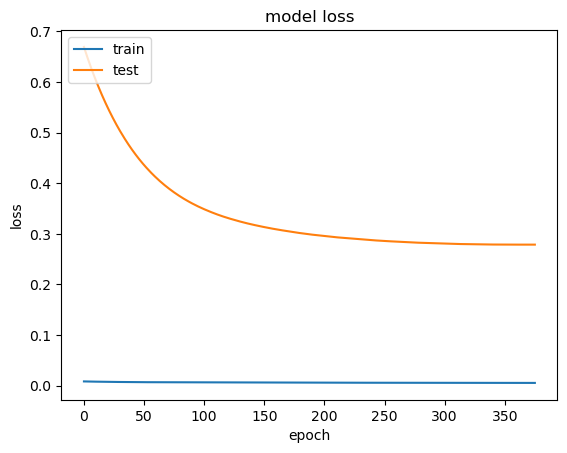

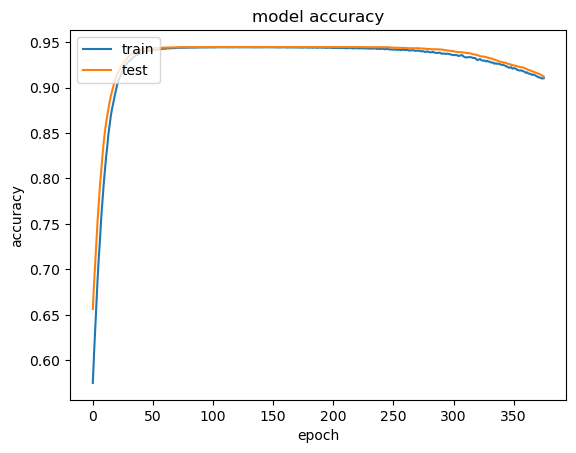

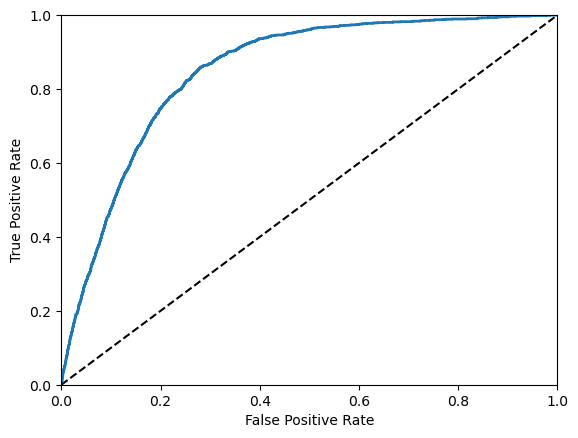

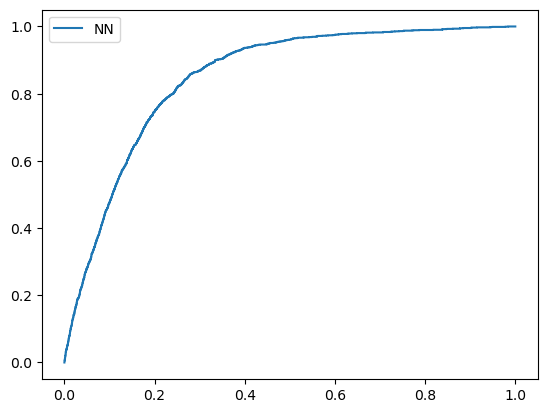

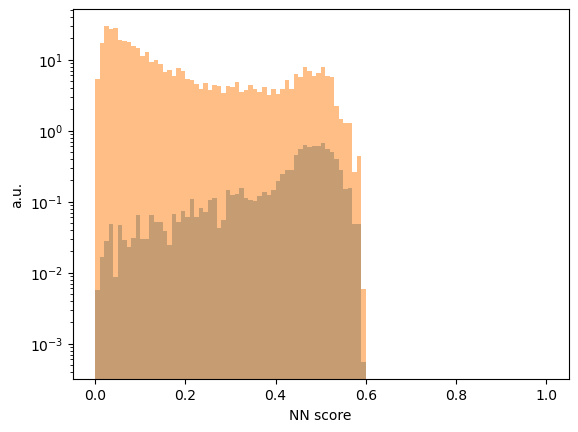

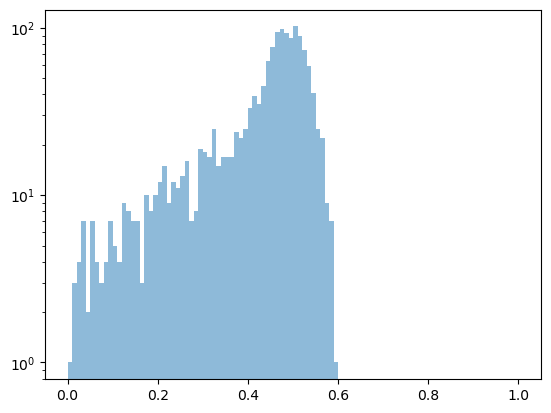

0.1010598415184907
4.433155111615939


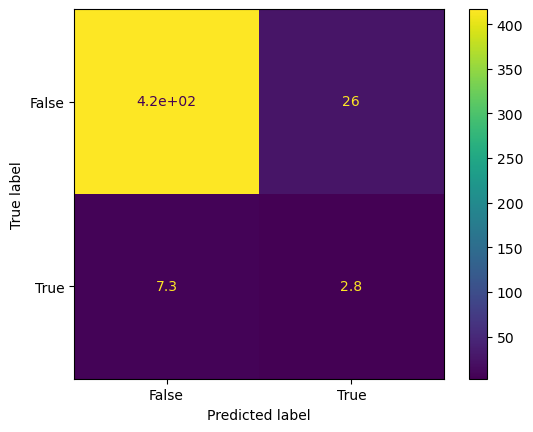

(27566,)


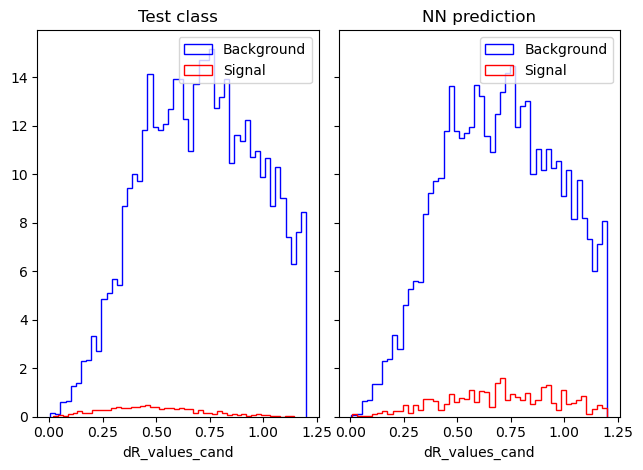

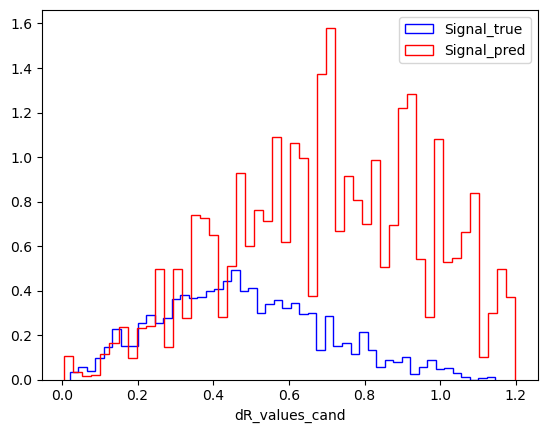

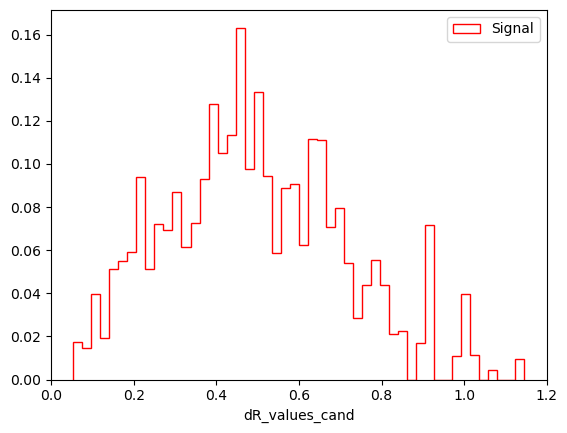

2.800161573863572


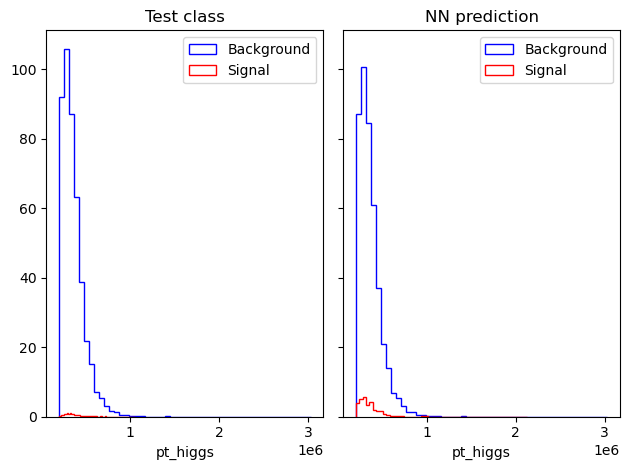

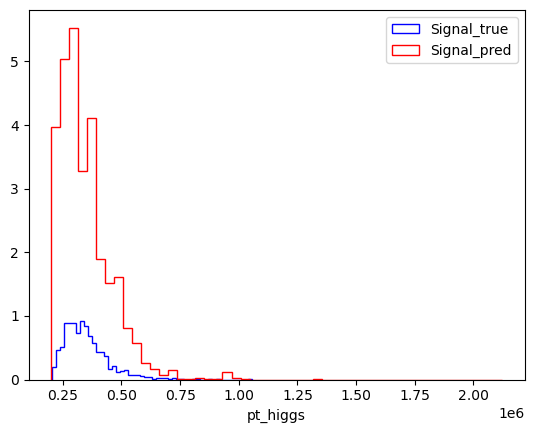

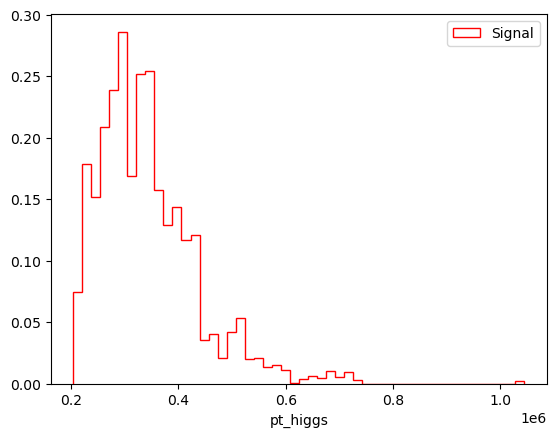

2.8001615738635732


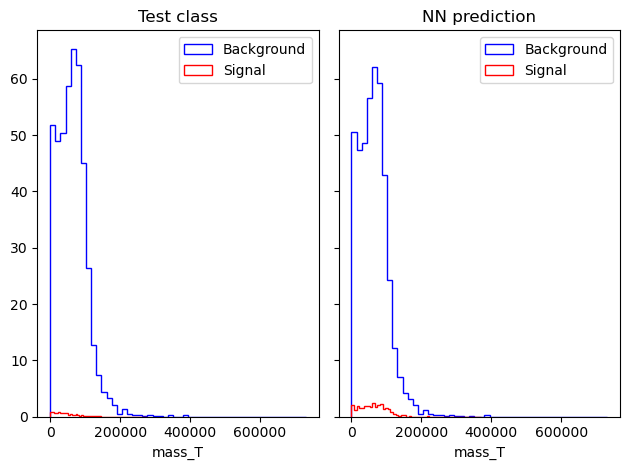

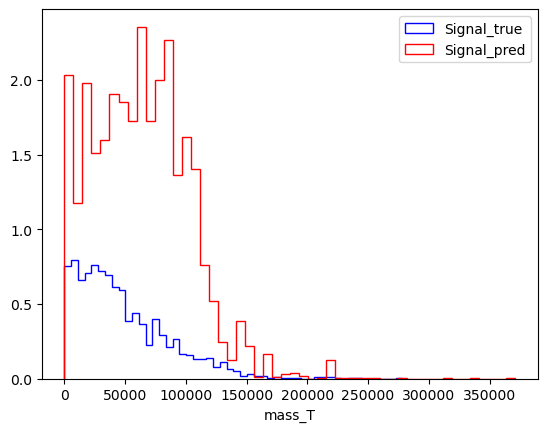

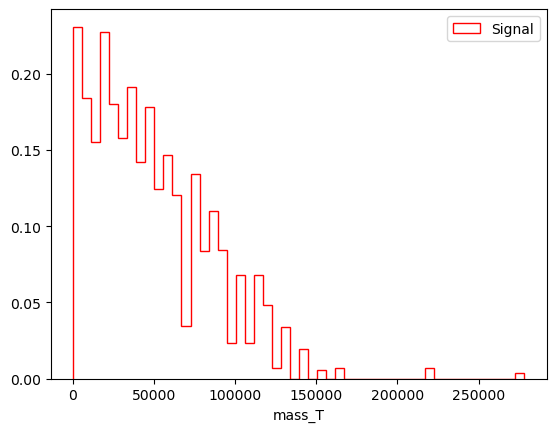

2.800161573863573


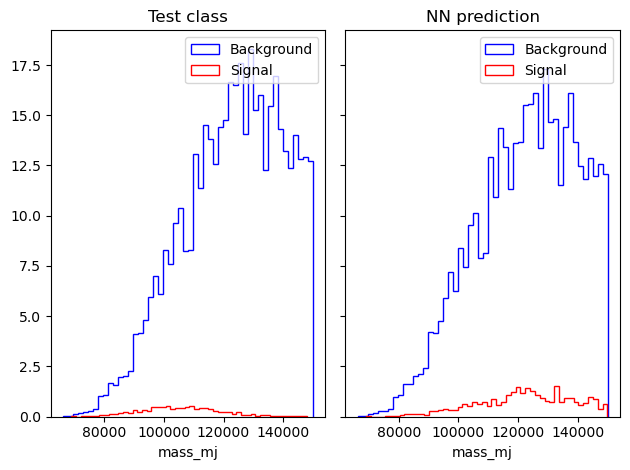

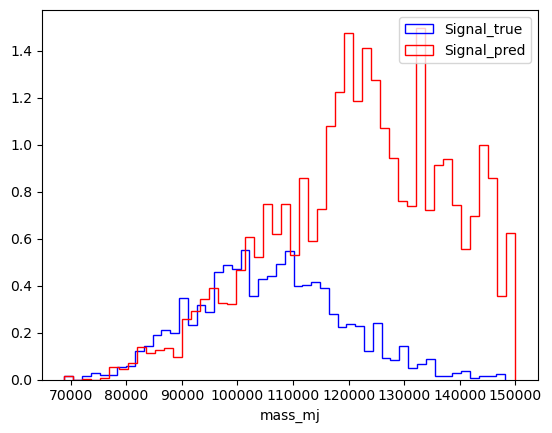

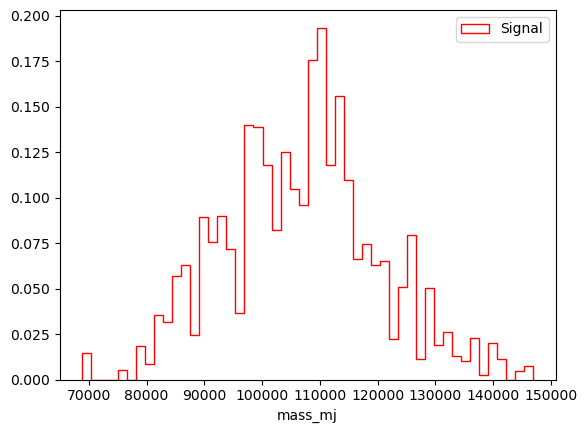

2.8001615738635723


In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# nn_model = keras.models.load_model('nn_model.h5')
# y_scores = nn_model.predict(scaled_test_df)
y_pred = np.round(y_scores)

nn_model.summary()

nn_signal_scores = y_scores[test_class == 1]
nn_background_scores = y_scores[test_class == 0]

nn_fakes, nn_reals, thresholds = roc_curve(test_class, y_scores)

print("NN AUC: ", auc(nn_fakes, nn_reals))

nn_loss_plot = plot_loss(nn_fit)
nn_accuracy_plot = plot_accuracy(nn_fit)

plot_roc_curve(nn_fakes, nn_reals)

#plot signal and background scores
plt.plot(nn_fakes, nn_reals, label="NN")
plt.legend()
plt.show()

#plot signal and background scores
entries, bin_edges, c = plt.hist(nn_signal_scores, bins=100, range=(0,1), alpha = 0.5, label='signal', weights=test_weight[test_class == 1])
entries1, bin_edges1, c1 = plt.hist(nn_background_scores, bins=100, range=(0,1), alpha = 0.5, label='background', weights=test_weight[test_class == 0])
plt.xlabel('NN score')
plt.ylabel('a.u.')
plt.yscale('log')
plt.show()
plt.hist(nn_signal_scores, bins=100, range=(0,1), alpha = 0.5, label='background')
plt.yscale('log')
plt.show()

#sum of weights
print(sum(entries * np.diff(bin_edges)))
print(sum(entries1 * np.diff(bin_edges1)))

#plot confusion matrix
confmatrix = confusion_matrix(test_class, y_pred, sample_weight=test_weight)
cm_display = ConfusionMatrixDisplay(confusion_matrix = confmatrix, display_labels = [False, True])
cm_display.plot()
plt.show()

#plot all test distributions with test_class and y_pred using subplots
y_pred = y_pred.flatten()
print(y_pred.shape)
for i in range(len(test_df.columns)):
    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, tight_layout=True)
    axs[0].hist(test_df[test_df.columns[i]][test_class == 0], bins= 50, histtype='step', label='Background', color='blue', weights=test_weight[test_class == 0])
    axs[0].hist(test_df[test_df.columns[i]][test_class == 1], bins= 50, histtype='step', label='Signal', color='red', weights=test_weight[test_class == 1])
    axs[0].set_xlabel(test_df.columns[i])
    axs[0].set_title('Test class')
    axs[0].legend()
    axs[1].hist(test_df[test_df.columns[i]][y_pred == 0], bins= 50, histtype='step', label='Background', color='blue', weights=test_weight[y_pred == 0])
    axs[1].hist(test_df[test_df.columns[i]][y_pred == 1], bins= 50, histtype='step', label='Signal', color='red', weights=test_weight[y_pred == 1])
    axs[1].set_xlabel(test_df.columns[i])
    axs[1].set_title('NN prediction')
    axs[1].legend()
    plt.show()
    print("")
    print("")
    plt.hist(test_df[test_df.columns[i]][test_class == 1], bins= 50, histtype='step', label='Signal_true', color='blue', weights=test_weight[test_class == 1])
    plt.hist(test_df[test_df.columns[i]][y_pred == 1], bins= 50, histtype='step', label='Signal_pred', color='red', weights=test_weight[y_pred == 1])
    plt.xlabel(test_df.columns[i])
    plt.legend()
    plt.show()
    print("")
    print("")
    # plt.hist(test_df[test_df.columns[i]][(test_class == 0) & (y_pred == 0)], bins= 50, histtype='step', label='Background', color='blue', weights=test_weight[(test_class == 0) & (y_pred == 0)])
    entries2, bin_edges2, c2 = plt.hist(test_df[test_df.columns[i]][(test_class == 1) & (y_pred == 1)], bins= 50, histtype='step', label='Signal', color='red', weights=test_weight[(test_class == 1) & (y_pred == 1)])
    plt.xlabel(test_df.columns[i])
    plt.legend()
    plt.show()
    print(sum(entries2))
